In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits
import seaborn as sns
from datetime import datetime

from populate_db import generate

%matplotlib inline

In [4]:
max_values = 10000
# generate amount of data
generate(max_values)

In [5]:
data = pd.read_csv("data.csv")

In [6]:
data.head()

,probe,weight,jew_type,jew_weight,complexity,price
0,600,5,3,6,2,305966.21
1,585,6,3,2,4,404875.50
2,600,9,7,4,4,932696.14
3,585,6,3,8,3,519433.94
4,700,9,1,6,4,832425.00


In [7]:
data.describe()

,probe,weight,jew_type,jew_weight,complexity,price
count,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,596.479500,5.4996,5.506300,5.496300,2.993400,7.284435e+05
std,71.551559,2.8750,2.877949,2.867997,1.415824,6.068717e+05
min,500.000000,1.0000,1.000000,1.000000,1.000000,2.546678e+04
25%,500.000000,3.0000,3.000000,3.000000,2.000000,3.174849e+05
50%,600.000000,5.0000,5.000000,5.000000,3.000000,5.432243e+05
75%,700.000000,8.0000,8.000000,8.000000,4.000000,9.512834e+05
max,700.000000,10.0000,10.000000,10.000000,5.000000,4.560782e+06


<function seaborn.utils.despine>

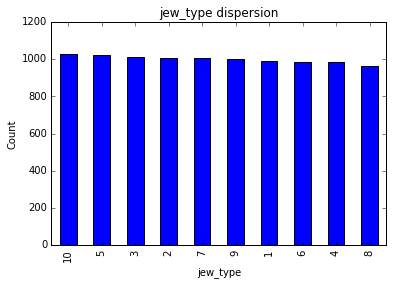

In [8]:
data['jew_type'].value_counts().plot(kind='bar')
plt.title('jew_type dispersion')
plt.xlabel('jew_type')
plt.ylabel('Count')
sns.despine

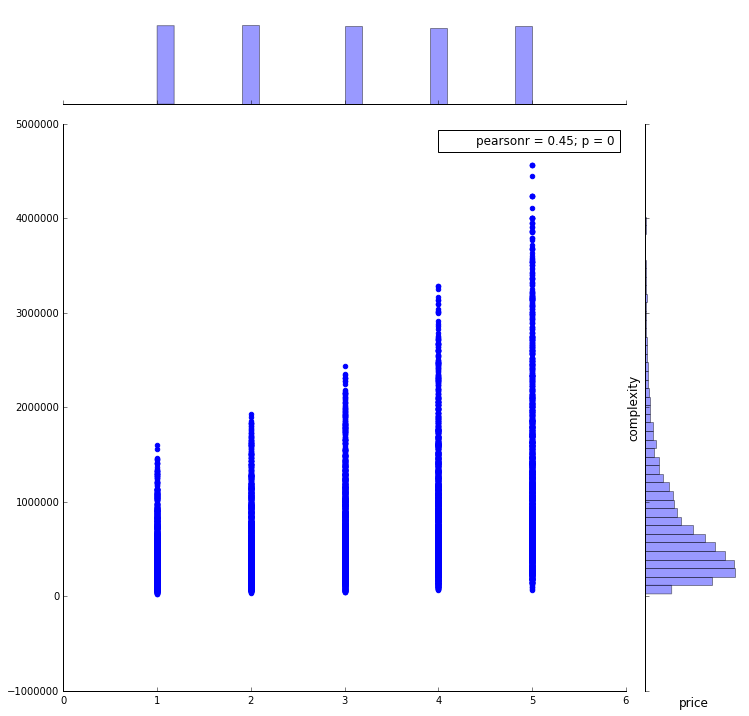

<function seaborn.utils.despine>

In [9]:
plt.figure(figsize=(10,10))
sns.jointplot(x=data.complexity.values, y=data.price.values, size=10)
plt.ylabel('complexity', fontsize=12)
plt.xlabel('price', fontsize=12)
plt.show()
sns.despine

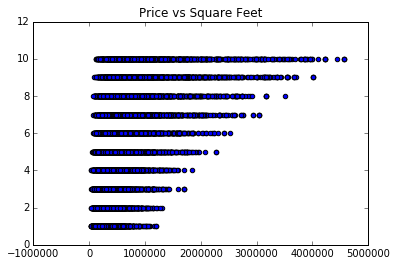

In [10]:
plt.scatter(data.price,data.jew_type)
plt.title("Price vs Square Feet")

In [11]:
labels = data['price']
train1 = data.drop(['price'],axis=1)

In [12]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train1, labels, test_size = 0.10, random_state =2)

/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
from sklearn import ensemble
# -15min on 1M entries (20.5mb csv)
dt1 = datetime.now()

clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

dt2 = datetime.now()
print(dt2-dt1)

0:00:00.000108


In [14]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [15]:
clf.score(x_test,y_test)

0.99943206166251986

In [16]:
import pickle
with open('logmodel.pkl', 'wb') as f:
    pickle.dump(clf, f, 2) 

In [17]:
#Create a Dataframe with only the dummy variables
features = dict(zip(train1.columns,range(train1.shape[1])))
with open('columns.pkl', 'wb') as f:
    pickle.dump(features, f, 2)  

In [18]:
# koeff stored in 
# clf.feature_importances_
f_importances = list(zip(features, clf.feature_importances_))
print(f_importances)

[('probe', 0.063185863061682807), ('weight', 0.18175751106825244), ('jew_type', 0.27527198120875812), ('jew_weight', 0.26355276594816063), ('complexity', 0.21623187871314581)]


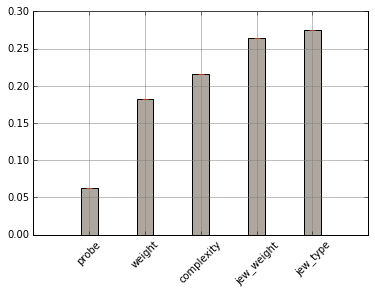

In [28]:
# display feature importance
importances_name = np.array([f[0] for f in f_importances])
importances_value = np.array([f[1] for f in f_importances])
indices = np.argsort(importances_value)

std = np.std([clf.feature_importances_,], axis=0)

fig = plt.figure()
plt.bar(range(len(indices)), importances_value[indices], width=0.3, color="#AEA79F",
        yerr=std[indices], ecolor="#DD4814", align="center")
plt.xticks(range(len(indices)), importances_name[indices], rotation=45)
plt.grid(color='gray', linestyle='-', linewidth=0.5)
#plt.xlim([-1, len(indices)])
#fig.set_tight_layout(True)
#fig.clf()

In [20]:
# lets see for the calculated data

test_data_head = data.head(10)

predicted = []
percents = []
errors = []
for row in test_data_head.itertuples():
    pred_v = round(clf.predict([row[1:-1]])[0], 2)
    predicted.append(pred_v)
    perc = round(row[-1]/(pred_v*100), 2)
    percents.append(perc)
    errors.append(round(pred_v-row[-1],2))
    
test_data_head.assign(percent=pd.Series(np.array(percents)).values,
                      pred_price=pd.Series(np.array(predicted)).values,
                     abs_error=pd.Series(np.array(errors)).values)

#clf.predict([[585,2,9,2,2]])

,probe,weight,jew_type,jew_weight,complexity,price,abs_error,percent,pred_price
0,600,5,3,6,2,305966.21,4100.09,0.01,310066.30
1,585,6,3,2,4,404875.50,13092.30,0.01,417967.80
2,600,9,7,4,4,932696.14,2070.68,0.01,934766.82
3,585,6,3,8,3,519433.94,-12320.47,0.01,507113.47
4,700,9,1,6,4,832425.00,-1464.83,0.01,830960.17
5,600,8,4,8,1,437097.58,4886.96,0.01,441984.54
6,585,1,8,4,1,239872.00,13086.63,0.01,252958.63
7,500,1,4,6,5,442561.13,-20178.95,0.01,422382.18
8,700,5,1,6,2,295053.97,2993.22,0.01,298047.19
9,700,8,5,5,4,982662.07,29167.46,0.01,1011829.53


2009957.94
[('probe', 127000), ('weight', 365324), ('jew_type', 553285), ('jew_weight', 529729), ('complexity', 434616)]
[0 1 4 3 2]


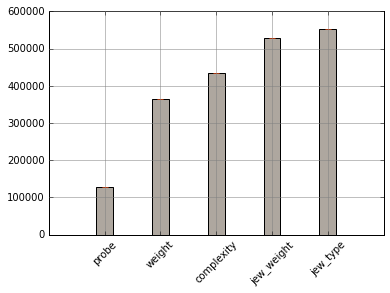

In [27]:
row = [585,9,6,9,5]
#row = [700,1,1,1,1]
predict = round(clf.predict([row])[0], 2)
print(predict)
price_imp = list(zip(features, [int(fi*predict) for fi in clf.feature_importances_]))
print(price_imp)


importances_name = np.array([f[0] for f in price_imp])
importances_value = np.array([f[1] for f in price_imp])
indices = np.argsort(importances_value)
print(indices)


std = np.std([clf.feature_importances_,], axis=0)

fig = plt.figure()
plt.bar(range(len(indices)), importances_value[indices], width=0.3, color="#AEA79F",
        yerr=std[indices], ecolor="#DD4814", align="center")

plt.xticks(range(len(indices)), importances_name[indices], rotation=45)
plt.grid(color='gray', linestyle='-', linewidth=0.5)